In [1]:
import numpy as np


In [29]:
class MultiIndexHash(object):

    def __init__(self,codes,m=None):
        self.N = codes.shape[0]
        self.Q = codes.shape[1]
        
        self.codes = codes
        
        if not m:
            m = codes.shape[1]//np.log2(self.N)
            
        self.m = int(m)
        self.s = np.array_split(np.arange(self.Q),self.m)
        
        self.tables = self.init_tables()
        
        
    def init_tables(self):
        '''creates multi-index hash tables
           codes - a NxQ binary array with N vectors of length Q
           m - number of tables to build, if empty, will compute optimal number'''
        tables = []

        for j in range(self.m):
            table = {}
            for i in range(self.N):
                substr = tuple(self.codes[i,self.s[j]])
                if substr not in table:
                    table[substr] = []
                table[substr].append(i)
            tables.append(table)

        return tables
    
    def r_search(self,query,r):
        
        r_ = r // self.m
        a = r % self.m
        
        neighbors = set()
        
        ## Search for neighbors using substring hash tables
        for j in range(self.m):
            if j < a:
                r_search = r_
            else:
                r_search = r_ - 1
            
            
            sub_index = self.s[j]
            q_sub = query[sub_index]
            
                        
            candidates = self.tables[j][tuple(q_sub)]
            codes_sub = self.codes[np.ix_(candidates,sub_index)]

            import pdb
            #pdb.set_trace()
            q_sub = np.reshape(q_sub,(1,-1))
            dist = np.sum(np.logical_xor(q_sub,codes_sub), axis=1) ##Hamming Distance

            for n in np.argwhere(dist <= r_search).flatten():
                #print(n)
                neighbors.add(candidates[n])
            
        ## Check all neighbors using full Hamming Distance
        
        
        neighbors = np.array(list(neighbors))
        codes_n = self.codes[neighbors,:]
        dist = np.sum(np.logical_xor(query,codes_n), axis=1)
        
        results = {}
        for n in np.argwhere(dist <= r).flatten():
            results[neighbors[n]] = dist[n]
        return sorted(results.items(), key = lambda x: x[1])
    
    def k_nn(self,query,k):
        neighbors = [set() for i in range(self.Q)]
        near = 0
        j = 0
        r = 0
        r_ = 0
        while near < k:
            sub_index = self.s[j]
            q_sub = query[sub_index]
            
            look_up = self.tables[j][tuple(q_sub)]
            codes_sub = self.codes[np.ix_(look_up,sub_index)]
            
            q_sub = np.reshape(q_sub,(1,-1))
            dist = np.sum(np.logical_xor(q_sub,codes_sub), axis=1) ##Hamming Distance
            
            candidates = set()
            for n in np.argwhere(dist <= r_).flatten():
                candidates.add(look_up[n])
                
            candidates = np.array(list(candidates))
            codes_n = self.codes[candidates,:]
            dist = np.sum(np.logical_xor(query,codes_n), axis=1)
            
            for i in range(candidates.shape[0]):
                d = dist[i]
                neighbors[d].add(candidates[i])
                
            near = sum(list(len(neighbors[d]) for d in range(r)))
            
            j += 1
            if j >= self.m:
                j = 0
                r_ += 1
                
            r += 1
            
        out = []
        for d in range(r):
            for n in neighbors[d]:
                out.append((n,d))
        return out

In [12]:
import pickle
feat = pickle.load(open('Data/feature_matrix/FC6_full_trained.p','rb'))

In [13]:
f = feat > 0

In [32]:
import time
start = time.time()
MIH = MultiIndexHash(f)
print('{:.2f} s'.format(time.time()-start))

19.91 s


In [33]:
%timeit MIH.k_nn(f[100,:],10)

436 ms ± 10.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
import pandas as pd
bbox = pd.read_table('Data/DeepFashion/list_bbox.txt',sep='\s+')
cat = pd.read_table('Data/DeepFashion/list_category_img.txt',sep='\s+')

In [37]:
df = pickle.load(open('Data/feature_matrix/DF20000_bbox.p','rb'))

In [38]:
df['category_label'] = cat.iloc[df.index]['category_label']

In [39]:
def test_pairs(N,image_df,MIH,feature_matrix):
    img_index = np.random.randint(image_df.shape[0],size=N)
    cat_match = []
    for i in img_index:
        j = 0
        match = MIH.k_nn(feature_matrix[i,:],1500)
        dist = match[j][1]
        n = match[j][0]
        while (dist<=0 & j<len(match)-1):
            j += 1
            dist = match[j][1]
            n = match[j][0]

        cat_match.append(image_df.iloc[i]['category_label'] == image_df.iloc[n]['category_label'])
        
    return cat_match

In [111]:
start = time.time()
matches = test_pairs(1000,df,MIH,f)
print('{:.3f} s'.format(time.time()-start))
print('{:.3f} match'.format(np.mean(matches)))

61.761 s
0.538 match


# Full Set

In [41]:
class MacOSFile(object):
    def __init__(self, f):
        self.f = f

    def __getattr__(self, item):
        return getattr(self.f, item)

    def read(self, n):
        if n >= (1 << 31):
            buffer = bytearray(n)
            pos = 0
            while pos < n:
                size = min(n - pos, 1 << 31 - 1)
                chunk = self.f.read(size)
                buffer[pos:pos + size] = chunk
                pos += size
            return buffer
        return self.f.read(n)

In [42]:
df = bbox.join(cat,lsuffix='_',rsuffix='')

In [43]:
with open('Data/feature_matrix/fc6_full_set.p','rb') as f:
    feat = pickle.load(MacOSFile(f))

In [129]:
f = feat > 0

In [45]:
import time
start = time.time()
MIH = MultiIndexHash(f)
print('{:.2f} s'.format(time.time()-start))

270.80 s


In [47]:
start = time.time()
matches = test_pairs(1000,df,MIH,f)
print('{:.3f} s'.format(time.time()-start))
print('{:.3f} match'.format(np.mean(matches)))

1323.847 s
0.631 match


In [ ]:
subset = np.random.randint(feat.shape[0],size=10)

In [90]:
%time for i in subset: MIH.k_nn(f[i,:],5)

KeyboardInterrupt: 

In [91]:
%time for i in subset: MIH.r_search(f[i,:],1500)

CPU times: user 10.6 s, sys: 2.69 s, total: 13.3 s
Wall time: 13.4 s


In [62]:
%matplotlib inline
import matplotlib.pyplot as plt

In [59]:
start = time.time()

subset = np.random.randint(feat.shape[0],size=50)
n_500 = []
for i in subset:
    n_500.append(len(MIH.r_search(f[i,:],500)))
    
print('{:.3f} s'.format(time.time()-start))

15.666 s


0.24


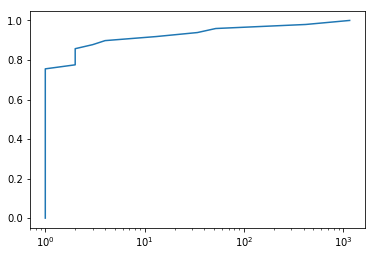

In [74]:
data_sorted = np.sort(n_500)

# calculate the proportional values of samples
p = 1. * np.arange(len(n_500)) / (len(n_500) - 1)
plt.semilogx(data_sorted,p)
print(np.mean(np.array(n_500)>1))

In [75]:
start = time.time()

subset = np.random.randint(feat.shape[0],size=50)
n_750 = []
for i in subset:
    n_750.append(len(MIH.r_search(f[i,:],750)))
    
print('{:.3f} s'.format(time.time()-start))

15.494 s


0.66


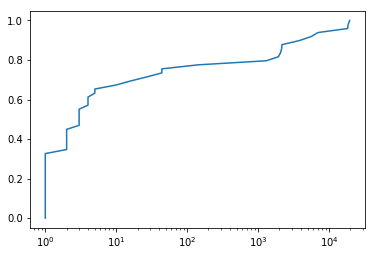

In [76]:
data_sorted = np.sort(n_750)

# calculate the proportional values of samples
p = 1. * np.arange(len(n_750)) / (len(n_750) - 1)
plt.semilogx(data_sorted,p)
print(np.mean(np.array(n_750)>1))

In [77]:
start = time.time()

subset = np.random.randint(feat.shape[0],size=50)
n_1000 = []
for i in subset:
    n_1000.append(len(MIH.r_search(f[i,:],1000)))
    
print('{:.3f} s'.format(time.time()-start))

12.699 s


0.86


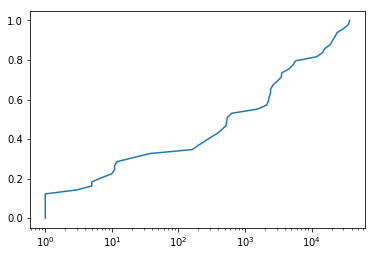

In [78]:
data_sorted = np.sort(n_1000)

# calculate the proportional values of samples
p = 1. * np.arange(len(n_1000)) / (len(n_1000) - 1)
plt.semilogx(data_sorted,p)
print(np.mean(np.array(n_1000)>1))

In [79]:
start = time.time()

subset = np.random.randint(feat.shape[0],size=50)
n_1500 = []
for i in subset:
    n_1500.append(len(MIH.r_search(f[i,:],1500)))
    
print('{:.3f} s'.format(time.time()-start))

13.794 s


1.0


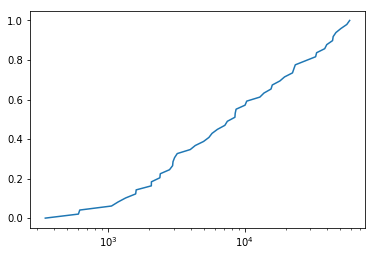

In [80]:
data_sorted = np.sort(n_1500)

# calculate the proportional values of samples
p = 1. * np.arange(len(n_1500)) / (len(n_1500) - 1)
plt.semilogx(data_sorted,p)
print(np.mean(np.array(n_1500)>1))

In [121]:
from IPython.display import display
import PIL
from PIL import ImageDraw



def draw_bbox(bbox):
    img = PIL.Image.open('Data/DeepFashion/'+bbox['image_name']).convert('RGBA')
    
    lx = bbox['x_1']
    ly = bbox['y_1']
    ux = bbox['x_2']
    uy = bbox['y_2']
    rect = PIL.Image.new('RGBA', img.size, (255,255,255,0))
    d = ImageDraw.Draw(img)
    d.rectangle(((lx,ly), (ux,uy)), outline="red")
    return PIL.Image.alpha_composite(img,rect)

def gen_pairs(N,image_df,MIH,feature_matrix):
    img_index = np.random.randint(image_df.shape[0],size=N)

    for i in img_index:
        j = 0
        match = MIH.r_search(feature_matrix[i,:],1000)
        dist = match[j][1]
        n = match[j][0]
        while (dist<=300 & j<len(match)-1):
            j += 1
            dist = match[j][1]
            n = match[j][0]
        print('{} dist: {:f}'.format(j,dist))
        display(draw_bbox(image_df.iloc[i]))
        display(draw_bbox(image_df.iloc[n]))

1 dist: 452.000000


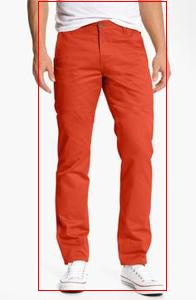

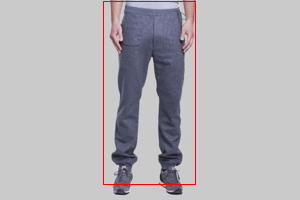

1 dist: 685.000000


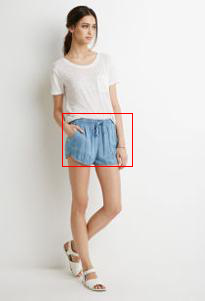

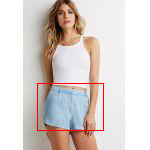

1 dist: 670.000000


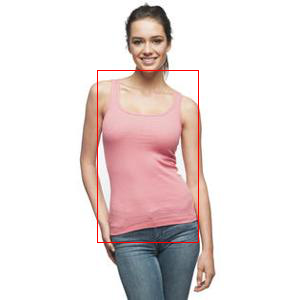

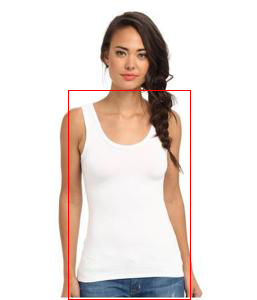

In [123]:
gen_pairs(3,df,MIH,f)

In [131]:
def write_pairs(N,k,image_df,MIH,feature_matrix):
    img_index = np.random.randint(image_df.shape[0],size=N)
    
    pairs = []
    
    for i in img_index:
        j = 0
        match = MIH.r_search(feature_matrix[i,:],1500)
        dist = match[j][1]
        n = match[j][0]
        while (dist<=300 & j<len(match)-1):
            j += 1
            dist = match[j][1]
            n = list(m[0] for m in match[j:(j+k)])
        
        s = image_df.iloc[i]['image_name']
        for m in n:
            s = s + "\t" + image_df.iloc[m]['image_name']
        pairs.append(s)
        
    return pairs

In [132]:
with open('fc6_full_MIH.txt', 'w') as file:
    file.write('\n'.join(write_pairs(300,3,df,MIH,f)))